# PRACTISE CASE SOCIAL MEDIA ANALYTICS 1
## BY DWI SMARADAHANA INDRALOKA
***

## Import Library

In [1]:
import pandas as pd 
import numpy as np 

#import nltk for natural language toolkit
import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords

#import string, regex, uniqcode
import re, string, unicodedata

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#import textblob 
from textblob import TextBlob
#textblob
from textblob import Word

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


## A. Data Preparation

### 1 Upload Dataset

In [2]:
data = pd.read_csv("tweets.csv")
data = data.rename_axis(index = "no")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
no,,,,,,,,,,,,,,,
0,5.675880e+17,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,@JetBlue's new CEO seeks the right balance to ...,NaN,2/16/2015,USA,Sydney
1,5.675900e+17,negative,1.0,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,2/16/2015,undecided,Pacific Time (US & Canada)
2,5.675910e+17,negative,1.0,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,@united yes. We waited in line for almost an h...,NaN,2/16/2015,"Washington, DC",NaN
3,5.675920e+17,negative,1.0,Late Flight,1.0000,United,NaN,brenduch,NaN,0,@united the we got into the gate at IAH on tim...,NaN,2/16/2015,NaN,Buenos Aires
4,5.675940e+17,negative,1.0,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,@SouthwestAir its cool that my bags take a bit...,NaN,2/17/2015,"Los Angeles, CA",Pacific Time (US & Canada)


### 2. Count the Percentage of Missing Value

In [3]:
percentage = round(data.isnull().sum()/len(data)*100, 2).sort_values(ascending = False)
percentage

negativereason_gold             99.78
airline_sentiment_gold          99.72
tweet_coord                     93.05
negativereason                  37.30
user_timezone                   32.97
tweet_location                  32.36
negativereason_confidence       28.09
tweet_created                    0.00
text                             0.00
retweet_count                    0.00
name                             0.00
airline                          0.00
airline_sentiment_confidence     0.00
airline_sentiment                0.00
tweet_id                         0.00
dtype: float64

### 3. Drop the Unused Columns

In [4]:
data.drop(["tweet_id", "airline_sentiment_confidence", "negativereason_confidence", "airline_sentiment_gold", "name", "negativereason_gold", "retweet_count", "tweet_coord", "tweet_location", "user_timezone", "tweet_created"], axis = 1, inplace = True)
data.head()

,airline_sentiment,negativereason,airline,text
no,,,,
0,neutral,NaN,Delta,@JetBlue's new CEO seeks the right balance to ...
1,negative,Can't Tell,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...
2,negative,Late Flight,United,@united yes. We waited in line for almost an h...
3,negative,Late Flight,United,@united the we got into the gate at IAH on tim...
4,negative,Customer Service Issue,Southwest,@SouthwestAir its cool that my bags take a bit...


In [5]:
data.shape

(14485, 4)

## B. Data Preprocessing

### 1. Data Cleansing

In [6]:
#function for data cleansing (url removal, punctuation removal, non ascii removal, lower casing)
def preprocessing(text):
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    def remove_between_square_brackets(text):
        return re.sub("-\[[^]]*\]", "", text)
    def denoise_text(text):
        text = strip_html(text)
        text = remove_between_square_brackets(text)
        return text
    def remove_punctuation(text):
        return re.sub(r"[^\w\s]", "", text)
    def remove_non_ascii(text):
        return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    text = remove_non_ascii(text)
    
    return text.lower()

In [7]:
data["text"] = data["text"].progress_apply(preprocessing)

100%|██████████| 14485/14485 [00:01<00:00, 8154.86it/s]


### 2. Stopwords Removal

In [8]:
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### 3. Lemmatization

In [9]:
data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

### 4. Frequent words removal

In [10]:
freq = pd.Series(' '.join(data['text']).split()).value_counts()[:8]
freq

flight          4465
united          4143
usairways       3043
americanair     2801
southwestair    2453
jetblue         2360
get             1363
hour            1123
dtype: int64

In [11]:
freq = list(freq.index)
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

## C. Data Exploration

### 1. Total Number of Tweets for Each Sentiment

Text(0, 0.5, 'Number in %')

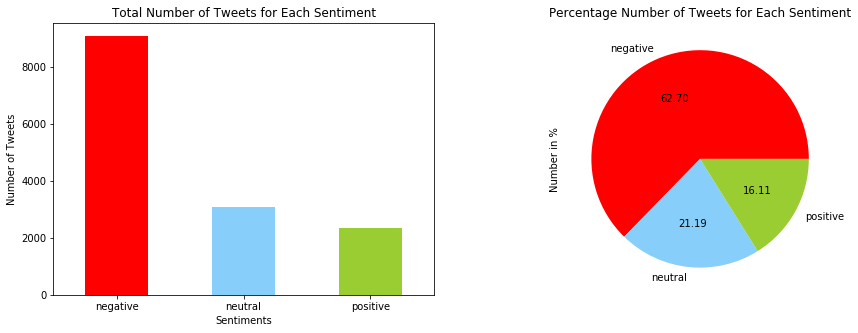

In [12]:
f = plt.figure(figsize = (15,5))

#make bar plot 
f.add_subplot(1, 2, 1)
colors = ['red', 'lightskyblue', 'yellowgreen']
pd.Series(data["airline_sentiment"]).value_counts().plot(kind = "bar", color = colors, rot = 0, title = "Total Number of Tweets for Each Sentiment")
plt.xlabel('Sentiments', fontsize = 10)
plt.ylabel('Number of Tweets', fontsize = 10)

#make pie chart 
f.add_subplot(1, 2, 2)
colors = ['red', 'lightskyblue', 'yellowgreen']
pd.Series(data["airline_sentiment"]).value_counts().plot(kind = "pie", colors = colors, labels = ["negative", "neutral", "positive"], autopct = '%.2f', title = "Percentage Number of Tweets for Each Sentiment")
plt.ylabel('Number in %')

***
Berdasarkan data di atas, dapat kita lihat bahwa sebagian besar tweet yang dibuat mengandung sentimen yang negatif (62.7%), hal tersebut menunjukkan bahwa pelayanan yang diberikan oleh maskapai-maskapai penerbangan masih kurang memuaskan, oleh karena itu perlu kita analisa lebih lanjut terkait hal-hal yang dikeluhkan oleh para pengguna layanan.
***

### 2. Total Number of Tweets for Each Sentiment for Each Airline

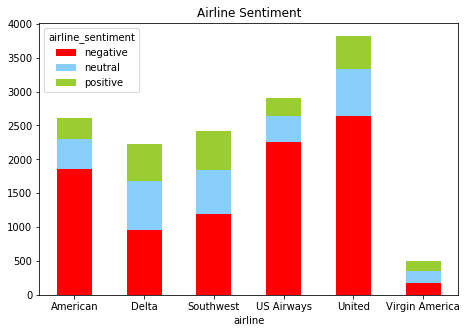

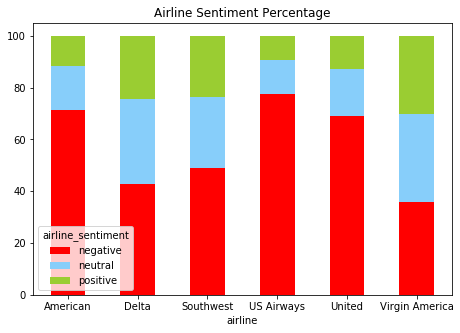

In [13]:
#calculate the percentage of each sentiment for each airlines
air_senti = pd.crosstab(data.airline, data.airline_sentiment)
percent = air_senti.apply(lambda a: a / a.sum() * 100, axis = 1)

#make stacked bar chart
colors = ['red', 'lightskyblue', 'yellowgreen']
pd.crosstab(index = data["airline"], columns = data["airline_sentiment"]).plot(kind = 'bar', figsize = (7.5, 5), color = colors, rot = 0, stacked = True, title = "Airline Sentiment")

#make stacked bar chart (percentage)
colors = ['red', 'lightskyblue', 'yellowgreen']
percent.plot(kind = 'bar', color = colors, figsize = (7.5, 5), rot = 0, stacked = True, title = "Airline Sentiment Percentage")

***
Berdasarkan data di atas, dapat kita lihat bahwa tweet dengan sentimen negatif paling banyak ditujukan kepada United Airline namun hal tersebut terjadi kemungkinan dikarenakan jumlah pengguna United Airline adalah yang paling banyak, sehingga kita perlu melihat presentase masing-masing sentimen pada tiap maskapai. Jika kita lihat dari presentase, maka US Airways lah yang memiliki jumlah presentase sentimen negatif dibandingkan dengan maskapai-maskapai lainnya. 
***

### 3. Word Cloud

In [14]:
#group the data for each sentiment
negative = data.loc[data['airline_sentiment'] == "negative"]
neutral  = data.loc[data['airline_sentiment'] == "neutral"]
positive = data.loc[data['airline_sentiment'] == "positive"]

#make text set for each sentiment
all_desc_negative = "".join(negative.text.values)
all_desc_neutral = "".join(neutral.text.values)
all_desc_positive = "".join(positive.text.values)

In [15]:
#function for creat word cloud
from PIL import Image
def create_word_cloud(string):
    mask = np.array(Image.open("Airplane.png"))
    cloud = WordCloud(background_color = "white", mask = mask, contour_width = 2, contour_color = 'steelblue', max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    cloud.to_file("Airplane_mask.png")
    plt.figure(figsize = (12, 6))
    plt.imshow(cloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

### 3.1 Negative Word Cloud

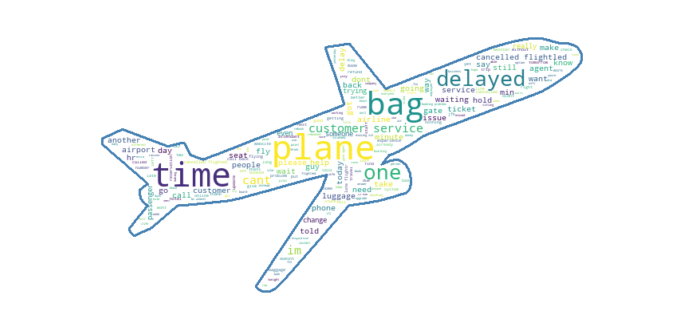

In [16]:
create_word_cloud(all_desc_negative)

***
Jika kita lihat dari word cloud di atas, tweet dengan sentimen negatif sebagian besar membahas permasalahan tentang pelayanan maskapai seperti adanya keterlambatan penerbangan, permasalahan customer service dan pembatalan penerbangan dimana secara garis besar yang berhubungan dengan waktu (time). Selain hal tersebut terdapat juga permasalahan terkait fasilitas maskapai seperti bagasi.
***

### 3.2 Neutral Word Cloud

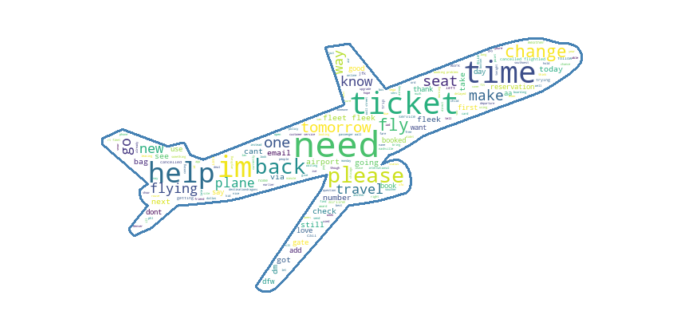

In [17]:
create_word_cloud(all_desc_neutral)

***
Jika kita lihat dari word cloud di atas, tweet dengan sentimen netral sebagian besar membahas tentang tiket, bantuan, permohonan dan jadwal. Apabila kita coba membuat asumsi, maka tweet dengan sentimen netral kebanyakan berisi tentang permintaan bantuan seperti merubah jadwal penerbangan, memilih tempat duduk, informasi jadwal penerbangan, pemesanan tiket pesawat dan lain sebagainya.
***

### 3.3 Positive Word Cloud

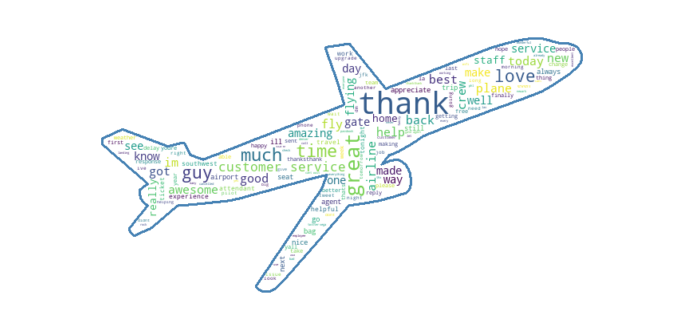

In [18]:
create_word_cloud(all_desc_positive)

***
Jika kita lihat dari word cloud di atas, tweet dengan sentimen positif sebagian besar berupa ucapan terima kasih dan pujian terhadap maskapai. Hal tersebut dapat kita lihat dari kata-kata yang paling banyak muncul seperti kata "thank", "great", "love", "best", "awesome" dan lain sebagainya.
***

### 4. Compare Negative Reasons in Existing Data with Negative Word Cloud Result

Text(0, 0.5, 'Number of Tweets')

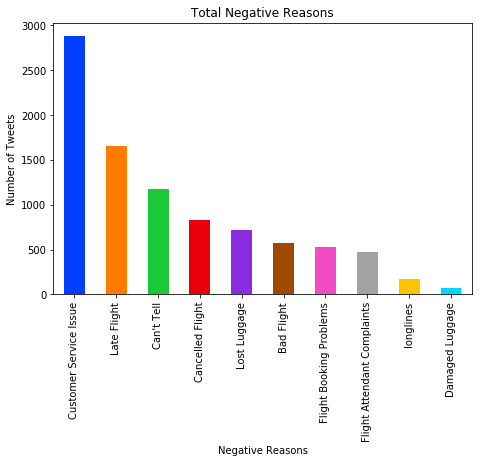

In [19]:
color = sns.color_palette("bright")
pd.Series(data["negativereason"]).value_counts().plot(kind = "bar", color = color, figsize = (7.5, 5), title = "Total Negative Reasons")
plt.xlabel('Negative Reasons', fontsize = 10)
plt.ylabel('Number of Tweets', fontsize = 10)

***
Jika kita lihat dari data di atas, negative reasons dari data existing menunjukkan hal yang sama dengan hasil negative word cloud dimana sebagian besar membahas permasalahan tentang pelayanan maskapai seperti permasalahan customer service, keterlambatan penerbangan dan pembatalan penerbangan. Selain hal tersebut terdapat juga permasalahan terkait fasilitas maskapai seperti bagasi yang mengakibatkan hilangnya koper dan rusaknya koper.
***

## D. Feature Extraction

### 1. Count Vectorizer 

In [20]:
count_vectorizer = CountVectorizer(stop_words='english')

### 2. TF-IDF Vectorizer 

In [21]:
tfidf = TfidfVectorizer(stop_words='english' )

## E. Modelling

### 1. Train Test Split

In [22]:
X = data["text"]
y = data["airline_sentiment"]

In [23]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

In [24]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y_v, test_y_v = train_test_split(X_vectorizer, y, test_size = 0.2, random_state = 0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size = 0.2, random_state = 0)

### 2. Model Machine Learning
* 2.1 Multinomial Logistic Regression
* 2.2 K-Nearest Neighbor
* 2.3 Support Vector Classification

### 2.1 Multinomial Logistic Regression

In [25]:
# Countvectorizer
Lr_vect = LogisticRegression(multi_class = "multinomial", solver ='newton-cg')
Lr_vect.fit(train_X_vectorizer, train_y_v)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)
pred_y_v = Lr_vect.predict(test_X_vectorizer)
print(pred_y_v)

['negative' 'neutral' 'negative' ... 'negative' 'positive' 'negative']


In [26]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression(multi_class = "multinomial", solver ='newton-cg')
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)
pred_y = Lr_vect.predict(test_X_tfidf)
print(pred_y)

['neutral' 'neutral' 'negative' ... 'neutral' 'positive' 'negative']


### 2.2 K-Nearest Neighbor

In [27]:
# Countvectorizer
KNN_vect = KNeighborsClassifier(n_neighbors = 3)
KNN_vect.fit(train_X_vectorizer,train_y_v)
KNN_pred_vect_train = KNN_vect.predict(train_X_vectorizer)
KNN_pred_vect_test = KNN_vect.predict(test_X_vectorizer)
pred_y_v = KNN_vect.predict(test_X_vectorizer)
print(pred_y_v)

['neutral' 'neutral' 'negative' ... 'neutral' 'positive' 'negative']


In [28]:
# TFIDFVectorizer
KNN_tfidf = KNeighborsClassifier(n_neighbors = 1000)
KNN_tfidf.fit(train_X_tfidf,train_y)
KNN_pred_tfidf_train = KNN_tfidf.predict(train_X_tfidf)
KNN_pred_tfidf_test = KNN_tfidf.predict(test_X_tfidf)
pred_y = KNN_vect.predict(test_X_tfidf)
print(pred_y)

['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']


### 2.3 Support Vector Classification

In [29]:
# Countvectorizer
SVM_vect = svm.SVC(gamma = "scale")
SVM_vect.fit(train_X_vectorizer,train_y_v)
SVM_pred_vect_train = SVM_vect.predict(train_X_vectorizer)
SVM_pred_vect_test = SVM_vect.predict(test_X_vectorizer)
pred_y_v = SVM_vect.predict(test_X_tfidf)
print(pred_y_v)

['negative' 'neutral' 'negative' ... 'neutral' 'positive' 'negative']


In [30]:
# TFIDFVectorizer
SVM_tfidf = svm.SVC(gamma = "scale")
SVM_tfidf.fit(train_X_tfidf,train_y)
SVM_pred_tfidf_train = SVM_tfidf.predict(train_X_tfidf)
SVM_pred_tfidf_test = SVM_tfidf.predict(test_X_tfidf)
pred_y = SVM_vect.predict(test_X_tfidf)
print(pred_y)

['negative' 'neutral' 'negative' ... 'neutral' 'positive' 'negative']


### 3. Model Evaluation
The following option are kind of model evaluation that used:
- Precision = precision_score()
- Recall = recall_score() 
- F_measure = f1_score()

### 3.1 Multinomial Logistic Regression

In [31]:
# using count vectorizer
print("______________ Countvectorizer ______________")

Lr_recall_vec_train = recall_score(train_y_v, Lr_pred_vect_train, average = "micro")
Lr_recall_vec_test = recall_score(test_y_v, Lr_pred_vect_test,average = "micro") 

Lr_precision_vec_train = precision_score(train_y_v, Lr_pred_vect_train,average = "micro")
Lr_precision_vec_test = precision_score(test_y_v, Lr_pred_vect_test,average = "micro")

Lr_f1_score_vec_train = f1_score(train_y_v, Lr_pred_vect_train,average = "micro")
Lr_f1_score_vec_test = f1_score(test_y_v, Lr_pred_vect_test,average = "micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 94.15% & 77.74%
Precision train & test  : 94.15% & 77.74%
F1 Score train & test   : 94.15% & 77.74%


In [32]:
# using TF-IDF vectorizer
print("______________ TF-IDF ______________")

Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y, Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 87.50% & 77.11%
Precision train & test  : 87.50% & 77.11%
F1 Score train & test   : 87.50% & 77.74%


### 3.2 K-Nearest Neighbor

In [33]:
# using count vectorizer
print("______________ Countvectorizer ______________")

KNN_recall_vec_train = recall_score(train_y_v, KNN_pred_vect_train, average="micro")
KNN_recall_vec_test = recall_score(test_y_v, KNN_pred_vect_test,average="micro") 

KNN_precision_vec_train = precision_score(train_y_v, KNN_pred_vect_train,average="micro")
KNN_precision_vec_test = precision_score(test_y_v, KNN_pred_vect_test,average="micro")

KNN_f1_score_vec_train = f1_score(train_y_v, KNN_pred_vect_train,average="micro")
KNN_f1_score_vec_test = f1_score(test_y_v, KNN_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (KNN_recall_vec_train * 100), '&', '%.2f%%' % (KNN_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (KNN_precision_vec_train * 100), '&', '%.2f%%' % (KNN_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (KNN_f1_score_vec_train * 100), '&', '%.2f%%' % (KNN_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 69.87% & 53.19%
Precision train & test  : 69.87% & 53.19%
F1 Score train & test   : 69.87% & 53.19%


In [34]:
# using TF-IDF vectorizer
print("______________ TF-IDF ______________")

KNN_recall_tfidf_train = recall_score(train_y, KNN_pred_tfidf_train, average="micro")
KNN_recall_tfidf_test = recall_score(test_y, KNN_pred_tfidf_test,average="micro") 

KNN_precision_tfidf_train = precision_score(train_y, KNN_pred_tfidf_train,average="micro")
KNN_precision_tfidf_test = precision_score(test_y, KNN_pred_tfidf_test,average="micro")

KNN_f1_score_tfidf_train = f1_score(train_y, KNN_pred_tfidf_train,average="micro")
KNN_f1_score_tfidf_test = f1_score(test_y, KNN_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (KNN_recall_tfidf_train * 100), '&', '%.2f%%' % (KNN_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (KNN_precision_tfidf_train * 100), '&', '%.2f%%' % (KNN_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (KNN_f1_score_tfidf_train * 100), '&', '%.2f%%' % (KNN_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 65.65% & 66.38%
Precision train & test  : 65.65% & 66.38%
F1 Score train & test   : 65.65% & 53.19%


### 3.3 Support Vector Classification

In [35]:
# using count vectorizer
print("______________ Countvectorizer ______________")

SVM_recall_vec_train = recall_score(train_y_v, SVM_pred_vect_train, average="micro")
SVM_recall_vec_test = recall_score(test_y_v, SVM_pred_vect_test,average="micro") 

SVM_precision_vec_train = precision_score(train_y_v, SVM_pred_vect_train,average="micro")
SVM_precision_vec_test = precision_score(test_y_v, SVM_pred_vect_test,average="micro")

SVM_f1_score_vec_train = f1_score(train_y_v, SVM_pred_vect_train,average="micro")
SVM_f1_score_vec_test = f1_score(test_y_v, SVM_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (SVM_recall_vec_train * 100), '&', '%.2f%%' % (SVM_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (SVM_precision_vec_train * 100), '&', '%.2f%%' % (SVM_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (SVM_f1_score_vec_train * 100), '&', '%.2f%%' % (SVM_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 92.10% & 76.60%
Precision train & test  : 92.10% & 76.60%
F1 Score train & test   : 92.10% & 76.60%


In [36]:
# using TF-IDF vectorizer
print("______________ TF-IDF ______________")

SVM_recall_tfidf_train = recall_score(train_y, SVM_pred_tfidf_train, average="micro")
SVM_recall_tfidf_test = recall_score(test_y, SVM_pred_tfidf_test,average="micro") 

SVM_precision_tfidf_train = precision_score(train_y, SVM_pred_tfidf_train,average="micro")
SVM_precision_tfidf_test = precision_score(test_y, SVM_pred_tfidf_test,average="micro")

SVM_f1_score_tfidf_train = f1_score(train_y, SVM_pred_tfidf_train,average="micro")
SVM_f1_score_tfidf_test = f1_score(test_y, SVM_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (SVM_recall_tfidf_train * 100), '&', '%.2f%%' % (KNN_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (SVM_precision_tfidf_train * 100), '&', '%.2f%%' % (KNN_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (SVM_f1_score_tfidf_train * 100), '&', '%.2f%%' % (KNN_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 95.75% & 66.38%
Precision train & test  : 95.75% & 66.38%
F1 Score train & test   : 95.75% & 53.19%


### 4. Conclusion

Berdasarkan hasil perbandingan tiga algoritma di atas, algoritma yang memberikan hasil paling baik adalah Multinomial Logistik Regression menggunakan TF-IDF Vectorizer dengan nilai Recall train & test: 87.50% & 77.11%, Precision train & test: 87.50% & 77.11% dan F1 Score train & test: 87.50% & 77.74%. Namun hasil tersebut masih belum bisa dikatakan valid dikarenakan tidak dilakukan pengaturan parameter-parameter terhadap masing-masing algoritma, dimana parameter-parameter yang dimiliki pada masing-masing algoritma bisa memberikan pengaruh besar terhadap hasil yang didapat.

***
Dalam hal bisnis, sentiment analysis bisa menjadi sesuatu yang sangat berguna. Suatu perusahaan bisa mengolah berbagai data masukan, kritikan dan keluhan dari pelayanan atau produk yang mereka tawarkan sehigga bisa mereka gunakan untuk memperbaiki kualitas dari pelayanan atau produk yang mereka tawarkan. Pada kasus di atas adalah sentiment analysis pada beberapa maskapai penerbangan dengan dengan menggunakan data tweet. Berdasarkan hasil yang didapat, sebagian besar tweet mengandung sentimen negatif yang berisi permasalahan tentang pelayanan maskapai seperti permasalahan customer service, keterlambatan penerbangan dan pembatalan penerbangan, selain hal tersebut terdapat juga permasalahan terkait fasilitas maskapai seperti bagasi yang mengakibatkan hilangnya koper dan rusaknya koper. Dengan mengetahui hal-hal tersebut, maka maskapai penerbangan dapat memperbaiki pelayanan dan fasilitas yang dimiliki secara tepat dan terfokus sehingga para pengguna maskapai tidak lagi banyak memberikan sentimen negatif dan akan banyak memberikan pujian dan ucapan terima kasih yang pada akhirnya akan membantu menarik pengguna lain untuk menggunakan maskapai tersebut.
***

***
# THANK YOU